# Final Project

**EMA 550**: Astrodynamics

In [1]:
%matplotlib widget

In [2]:
from utils.lamberts import *
from utils.propagator import *
from utils.constants import *
from utils.ephemerides import *
from utils.orbital_elements import *
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.ion()

_bold = '\033[1m'
_reset = '\033[0m'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Some utility constants
_moon_sma = pv_to_moe(pv=moon_ephemeris.pv0)[1]
_lunar_orbit_limits = [
    (-1*_moon_sma, _moon_sma),
    (-1*_moon_sma, _moon_sma),
    (-1*_moon_sma, _moon_sma)
]
_leo_limits = [
    (-1*EARTH.radius - 50000e3, EARTH.radius + 50000e3),
    (-1*EARTH.radius - 50000e3, EARTH.radius + 50000e3),
    (-1*EARTH.radius - 50000e3, EARTH.radius + 50000e3)
]
_lunar_limits = [
    (-1*MOON.radius - 5000e3, MOON.radius + 5000e3),
    (-1*MOON.radius - 5000e3, MOON.radius + 5000e3),
    (-1*MOON.radius - 5000e3, MOON.radius + 5000e3)
]

## Problem Parameters

In [4]:
# Time of flight
time_of_flight = 3*24*60*60 # 6 days
launch_time = Time("2022-04-16").unix
time_in_lunar_orbit = 50000

# Determine where the moon will be at intercept
moon_intercept_pv = moon_ephemeris.get_pv(t=launch_time+time_of_flight)
moon_intercept_coe = pv_to_moe(pv=moon_intercept_pv)

# Initial LEO Orbit
initial_leo_coe = make_coe(
    e=0.0,
    a=EARTH.radius+300e3,
    i=46.5 * np.pi / 180.0,
    raan=0.0,
    arg_peri=0.0,
    true_anom=0.0)
initial_leo_ephemeris = Ephemeris(
    pv=pv_from_moe(moe=initial_leo_coe),
    t=launch_time,
    central_body=EARTH)

In [5]:
print(f"{_bold}Initial LEO orbit{_reset}")
print_moe(moe=initial_leo_coe)

# Final orbit (for reference)
print()
print(f"{_bold}Moon's Orbit{_reset}")
print_moe(moe=pv_to_moe(pv=moon_ephemeris.get_pv(t=launch_time)))

Initial LEO orbit
Eccentricity:    0.0
SMA:             6678000.0 m
Inclination:     46.49999999999999 deg
Right Ascension: 0.0 deg
Arg Perigee:     0.0 deg
True Anom:       0.0 deg

Moon's Orbit
Eccentricity:    0.058182277595109376
SMA:             386167592.81358355 m
Inclination:     26.902672276788124 deg
Right Ascension: 9.180293108652695 deg
Arg Perigee:     246.58616807187357 deg
True Anom:       300.03654576153656 deg


## Lunar Transfer

In [6]:
# Determine where we want to target (nearish the moon)
moon_target_pv = moon_ephemeris.get_pv(t=launch_time+time_of_flight - 9140.2)

# Get the pv vector for the transfer orbit
transfer_v1, transfer_v2 = lamberts2(
    r1_vec=initial_leo_ephemeris.get_pv(t=launch_time)[:3],
    r2_vec=moon_target_pv[:3],
    dt=time_of_flight,
    central_body=EARTH)
transfer_pv1 = np.hstack((initial_leo_ephemeris.get_pv(t=launch_time)[:3], transfer_v1))
transfer_pv2 = np.hstack((moon_target_pv[:3], transfer_v2))
transfer_ephemeris = Ephemeris(pv=transfer_pv1, t=launch_time, central_body=EARTH)

# Determine the deltaV needed for entering the transfer orbit
entering_transfer_deltaV_vec = transfer_pv1[3:] - initial_leo_ephemeris.get_pv(t=launch_time)[3:]

# Determine the time at which the we enter the lunar sphere of influence
times, transfer_traj = transfer_ephemeris.get_traj(t0=launch_time, t1=launch_time+time_of_flight)
lunar_soi_entry_time = times[0]
for i in range(times.shape[0]):
    pv = transfer_traj[i,:]
    if(np.linalg.norm(pv[:3] - moon_ephemeris.get_pv(t=times[i])[:3]) < MOON.soi):
        lunar_soi_entry_time = times[i]
        break

# Get the lunar reference frame ephemeris
lunar_transfer_ephemeris = Ephemeris.earth_to_lunar(
    eci_ephemeris=transfer_ephemeris,
    moon_ephemeris=moon_ephemeris,
    t = lunar_soi_entry_time)

# Get the perigee altitude
lunar_perigee_radius = pv_to_perigee_radius(pv=lunar_transfer_ephemeris.get_pv(t=lunar_soi_entry_time), central_body=MOON)
lunar_perigee_alititude = lunar_perigee_radius - MOON.radius

# Get the time of perigee passage
time_of_lunar_perigee = lunar_soi_entry_time + -1*pv_to_perigee_passage(pv=lunar_transfer_ephemeris.get_pv(t=lunar_soi_entry_time), central_body=MOON)

# Get the velocity at the perigee
lunar_perigee_pv = lunar_transfer_ephemeris.get_pv(t=time_of_lunar_perigee)
lunar_perigee_velocity = lunar_perigee_pv[3:]

# Determine the velocity needed for a circular orbit at the given altitude
lunar_cirular_orbit_speed = np.sqrt(MOON.mu * (2/lunar_perigee_radius - 1/lunar_perigee_radius))

# Determine the velocity vector needed
lunar_orbit_initial_velocity = lunar_cirular_orbit_speed * lunar_perigee_velocity / np.linalg.norm(lunar_perigee_velocity)

# Find the lunar orbit initial PV
lunar_orbit_initial_pv = np.hstack((lunar_perigee_pv[:3], lunar_orbit_initial_velocity))

# Luanr orbit ephemeris
lunar_orbit_ephemeris = Ephemeris(pv=lunar_orbit_initial_pv, t=time_of_lunar_perigee, central_body=MOON)

# Determine the deltaV vector needed to enter lunar orbit
entering_lunar_orbit_deltaV_vec = lunar_orbit_initial_pv[3:] - lunar_perigee_velocity

In [7]:
print(f"{_bold}Transfer Orbit (ECI Frame){_reset}")
print_moe(moe=pv_to_moe(pv=transfer_pv1))

print(f"{_bold}Transfer Orbit (Lunar Frame){_reset}")
print_moe(moe=pv_to_moe(pv=lunar_transfer_ephemeris.get_pv(t=lunar_soi_entry_time), central_body=MOON))
                        
print(f"{_bold}Lunar Orbit (Lunar Frame){_reset}")
print_moe(moe=pv_to_moe(pv=lunar_orbit_ephemeris.get_pv(t=time_of_lunar_perigee), central_body=MOON))

print(f"{_bold}Other{_reset}")
print(f"Entering Lunar Transfer Delta V (m/s): {np.linalg.norm(entering_transfer_deltaV_vec)}")
print(f"Entering Lunar Orbit Delta V (m/s): {np.linalg.norm(entering_lunar_orbit_deltaV_vec)}")
print(f"Lunar SOI Entry Velocity (m/s): {np.linalg.norm(lunar_transfer_ephemeris.get_pv(t=lunar_soi_entry_time)[3:])}")
print(f"Lunar Perigee Altitue (m): {lunar_perigee_alititude} ({lunar_perigee_alititude / 1000.0} km.)")

Transfer Orbit (ECI Frame)
Eccentricity:    0.977579123200341
SMA:             220539185.646575 m
Inclination:     23.83007150488374 deg
Right Ascension: 0.0 deg
Arg Perigee:     61.644939896046395 deg
True Anom:       298.35506010395363 deg
Transfer Orbit (Lunar Frame)
Eccentricity:    1.430303274503898
SMA:             -4502592.716514116 m
Inclination:     25.330806203948317 deg
Right Ascension: 11.286090138200539 deg
Arg Perigee:     126.93996599131032 deg
True Anom:       229.5690596000037 deg
Lunar Orbit (Lunar Frame)
Eccentricity:    6.684743877517625e-11
SMA:             1937480.3896743467 m
Inclination:     25.330806203948285 deg
Right Ascension: 11.28609013820057 deg
Arg Perigee:     216.7360062725275 deg
True Anom:       270.2039597122332 deg
Other
Entering Lunar Transfer Delta V (m/s): 6630.490171482191
Entering Lunar Orbit Delta V (m/s): 889.3292810285708
Lunar SOI Entry Velocity (m/s): 1113.6360178028533
Lunar Perigee Altitue (m): 199980.38967342512 (199.98038967342512 km.

## Plot Trajectory

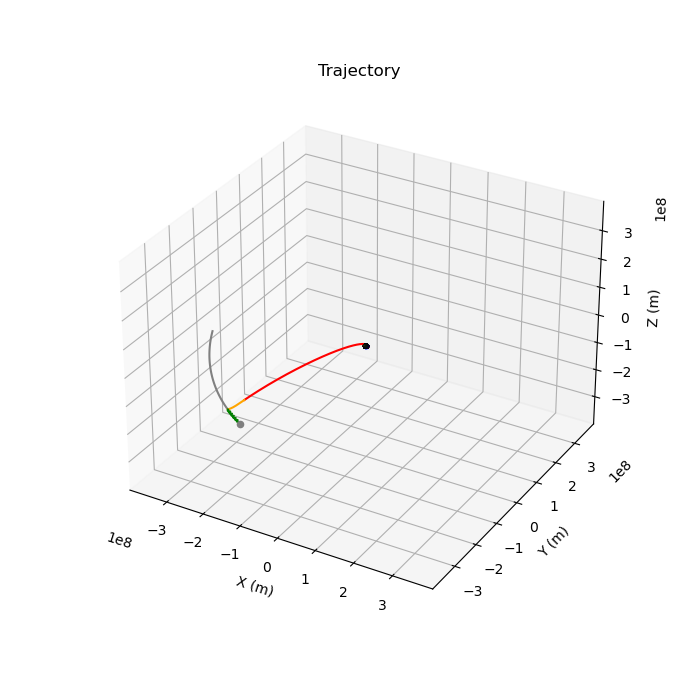

In [8]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(
    xlim=_lunar_orbit_limits[0],
    ylim=_lunar_orbit_limits[1],
    zlim=_lunar_orbit_limits[2])
plot_earth(
    ax=ax,
    label="Earth")

ax.set_title("Trajectory")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
#ax.legend()

##### interesting bits #####
moon_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=time_of_lunar_perigee + time_in_lunar_orbit,
    label="Moon",
    pathColor="grey",
    pointColor="grey")
initial_leo_ephemeris.plot(
    ax=ax,
    t0=launch_time-1000,
    t1=launch_time,
    label="Initial Orbit",
    pathColor="blue",
    pointColor=None)
transfer_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=lunar_soi_entry_time,
    label="Transfer Orbit",
    pathColor="red",
    pointColor=None)
lunar_transfer_ephemeris.plot_lunar_in_eci(
    ax=ax,
    t0=lunar_soi_entry_time,
    t1=time_of_lunar_perigee,
    label="Transfer Orbit",
    moon_ephemeris=moon_ephemeris,
    pathColor="orange",
    pointColor=None)
lunar_orbit_ephemeris.plot_lunar_in_eci(
    ax=ax,
    t0=time_of_lunar_perigee,
    t1=time_of_lunar_perigee+time_in_lunar_orbit,
    label="Lunar Orbit",
    moon_ephemeris=moon_ephemeris,
    pathColor="green",
    pointColor=None)

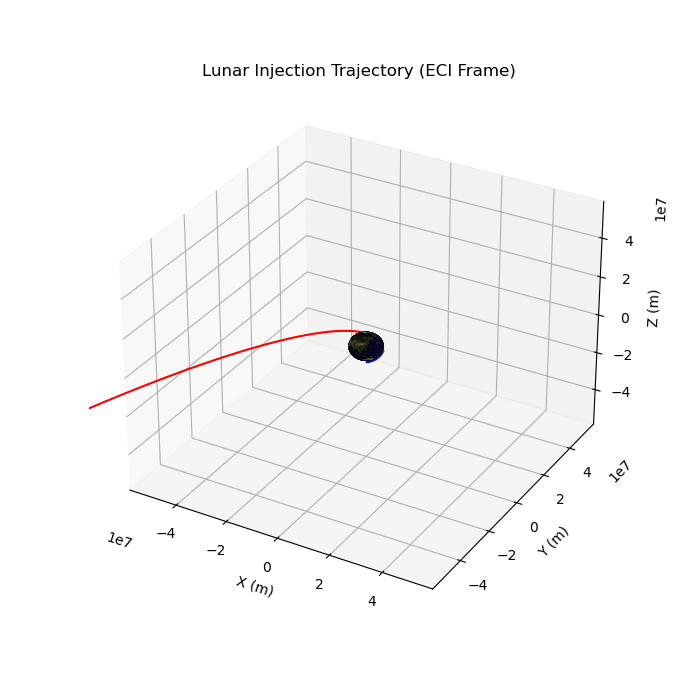

In [9]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(
    xlim=_leo_limits[0],
    ylim=_leo_limits[1],
    zlim=_leo_limits[2])
plot_earth(
    ax=ax,
    label="Earth")

ax.set_title("Lunar Injection Trajectory (ECI Frame)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
# ax.legend()

##### interesting bits #####
initial_leo_ephemeris.plot(
    ax=ax,
    t0=launch_time-1000,
    t1=launch_time,
    label="Initial Orbit",
    pathColor="blue",
    pointColor=None)
transfer_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=launch_time+time_of_flight,
    label="Transfer Orbit",
    pathColor="red",
    pointColor=None)

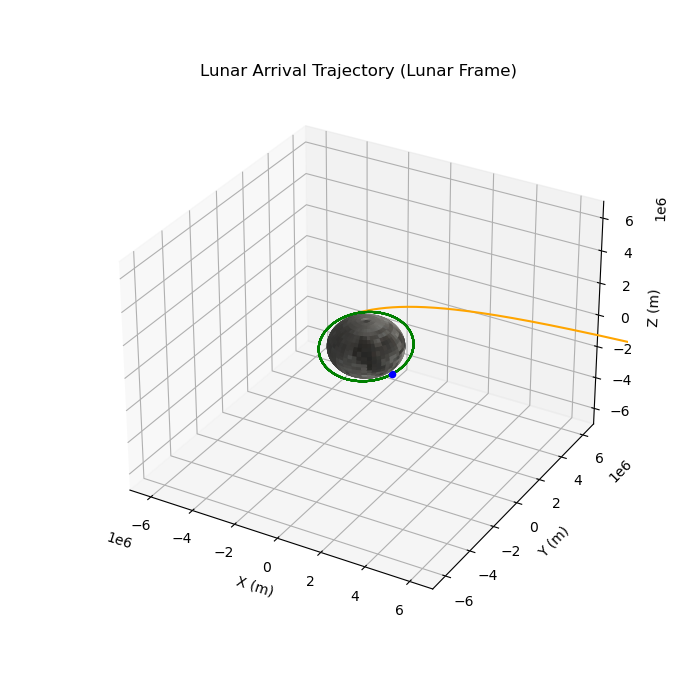

In [10]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(
    xlim=_lunar_limits[0],
    ylim=_lunar_limits[1],
    zlim=_lunar_limits[2])
plot_moon(
    ax=ax,
    label="Moon")

ax.set_title("Lunar Arrival Trajectory (Lunar Frame)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
# ax.legend()

##### interesting bits #####
transfer_ephemeris.plot_eci_in_lunar(
    ax=ax,
    t0=launch_time,
    t1=lunar_soi_entry_time,
    label="Transfer Orbit",
    moon_ephemeris=moon_ephemeris,
    pathColor="red",
    pointColor=None)
# Note that we dont use plot_lunar_in_eci() because this is in the lunar frame
lunar_transfer_ephemeris.plot(
    ax=ax,
    t0=lunar_soi_entry_time,
    t1=time_of_lunar_perigee,
    label="Transfer Orbit",
    pathColor="orange",
    pointColor=None)
lunar_orbit_ephemeris.plot(
    ax=ax,
    t0=time_of_lunar_perigee,
    t1=time_of_lunar_perigee + time_in_lunar_orbit,
    label="Luanr Orbit",
    pathColor="green",
    pointColor="blue")